<a href="https://colab.research.google.com/github/Jaime44/WorkSpace/blob/main/models/rnn_rs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

path_absolute = ''
if IN_COLAB:
    print("El código se está ejecutando en Google Colab.")
    from google.colab import drive

    drive.mount('/content/drive')
    path_absolute = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/Models/neural network'

    # Cambia al directorio de tu carpeta en Google Drive
    os.chdir(path_absolute)

    # Lista los archivos y carpetas en el directorio actual
    contenido_carpeta = os.listdir(path_absolute)
    print("Contenido de la carpeta en Google Drive:")
    print(contenido_carpeta)
else:
    print("El código se está ejecutando en un entorno local.")
    path_absolute = os.getcwd().replace("\\", "/")
    path_absolute = 'C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/Models/neural network'

datasets_path = "/datasets/"
path_absolute = path_absolute+datasets_path

path_workspace ='C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/'
sys.path.append(path_workspace)

El código se está ejecutando en un entorno local.


In [101]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import Utils.utils as util
import matplotlib.pyplot as plt


from pylab import rcParams
from keras.models import Model
from IPython.display import SVG
from wordcloud import WordCloud
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import model_to_dot
from keras.layers import Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split
from keras.layers import Embedding, Input, dot, concatenate
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop




# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

In [3]:
# dataFrame = pd.read_csv(path_absolute+'df_movies_rating_2.csv', sep=',')
# data = dataFrame.copy()

# tamano_muestra = 60000
# # Obtiene una muestra aleatoria uniforme del DataFrame
# data = data.sample(n=tamano_muestra, random_state=42)  # random_state para reproducibilidad


# # Quito las calumnas categoricas de título y tag ambas estan represnetadas en las columnas númericas de tag_encode e id movie.
# # util.contar_ocurrencias(data, '(no genres listed)')
# # util.mostrar_filas_por_valor(data, '(no genres listed)', 1)

# # Total de clases(Puntuaciones) a predecir
# # 4.0,5.0,3.5,4.5,3.0,2.5,1.0,1.5,0.5
# data = util.eliminar_columnas(data, ['tag', 'title', '(no genres listed)'])
# util.contar_ocurrencias(data, 'rating')

# data = util.eliminar_columnas(data, ['timestamp_tags', 'timestamp_scr'])

# data.head()

In [73]:
#Carga de datos y preprocesado

dataFrame = pd.read_csv(path_absolute+'/df_mezclado_tags_ratings_movies_links_genTags.csv')

print(dataFrame.shape)

data = dataFrame.copy()
data = data.sample(n=100000, random_state=42)

# Inserta la columna 'rating' en la última posición del DataFrame
data.insert(len(data.columns)-1, 'rating', data.pop('rating'))
# Inserta la columna 'relevance' en la penúltima posición del DataFrame
data.insert(len(data.columns)-2, 'relevance', data.pop('relevance'))
# Inserta la columna 'tag_etiquetas_genómicas' despues de tag_df_mezclado
data.insert(5, 'tag_etiquetas_genómicas', data.pop('tag_etiquetas_genómicas'))

# Renombrar algunas columnas:
data.rename(columns={'timestamp_valoraciones': 'timestamp_rt', 'timestamp_etiquetas': 'timestamp_tags', 'tag_df_mezclado_tags_ratings_movies_links_genMov': 'tag_by_user', 'tag_etiquetas_genómicas': 'gen_tag'}, inplace=True)

# Elimino las columnas:
columnas_a_eliminar = ['imdbId', 'tmdbId']
data = data.drop(columnas_a_eliminar, axis=1)
print(data.shape)
df = data.copy()
df.head()

(8949372, 13)
(100000, 11)


,userId,movieId,timestamp_rt,tag_by_user,timestamp_tags,gen_tag,title,genres,tagId,relevance,rating
1561133,60101,2571,1053445162,dystopia,1244667471,hitman,"Matrix, The (1999)",Action|Sci-Fi|Thriller,512,0.12625,5.0
1499330,42923,1228,1330057917,classic,1330057913,nocturnal,Raging Bull (1980),Drama,710,0.60700,4.0
1048680,7620,34532,1144937579,Magick,1144937622,true story,"Skeleton Key, The (2005)",Drama|Horror|Mystery|Thriller,1047,0.05750,5.0
1703441,62199,5636,1199318408,Anthony Russo,1328741490,adoption,Welcome to Collinwood (2002),Comedy|Crime,27,0.05325,3.0
5648649,29801,6250,1476349149,Stephen King,1476349186,cult film,Dreamcatcher (2003),Drama|Horror|Sci-Fi|Thriller,276,0.36500,2.0


## Explore dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8949372 entries, 0 to 8949371
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   userId          int64  
 1   movieId         int64  
 2   timestamp_rt    int64  
 3   tag_by_user     object 
 4   timestamp_tags  int64  
 5   gen_tag         object 
 6   title           object 
 7   genres          object 
 8   tagId           int64  
 9   relevance       float64
 10  rating          float64
dtypes: float64(2), int64(5), object(4)
memory usage: 751.1+ MB


In [6]:
# Valores nulos 
print(f"Valores nulos para la columna userId: {df['userId'].isnull().sum()}")
print(f"Valores nulos para la columna rating: {df['rating'].isnull().sum()}")
print(f"Valores nulos para la columna movieId: {df['movieId'].isnull().sum()}")

Valores nulos para la columna userId: 0
Valores nulos para la columna rating: 0
Valores nulos para la columna movieId: 0


In [7]:
# Se cuenta los valores unicos de rating
df['rating'].value_counts()

4.0    2067570
5.0    1901803
4.5    1518686
3.5    1349780
3.0     895858
2.5     437718
2.0     335858
1.5     167000
1.0     148428
0.5     126671
Name: rating, dtype: int64

In [8]:
# Se cuenta los valores unicos de usuarios
df['userId'].value_counts()

6550      217078
160540    128670
155146    126249
131347    102899
14116      92277
           ...  
152361         3
107106         3
46748          3
81807          3
113230         3
Name: userId, Length: 12918, dtype: int64

In [9]:
# Se cuenta los valores unicos de peliculas
df['movieId'].value_counts()

296       84546
260       66668
2571      56432
79132     46900
4973      38592
          ...  
4879          4
2873          3
5289          3
4113          3
147300        3
Name: movieId, Length: 12105, dtype: int64

In [10]:
rango_valores = df['rating'].describe()['min'], df['rating'].describe()['max']
print("Rango de valores cd rating:", rango_valores)

Rango de valores cd rating: (0.5, 5.0)


In [11]:
#promedio de calificaciones agrupado por titulos
df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Take Care of My Cat (Goyangileul butaghae) (2001)                      5.0
Celine and Julie Go Boating (Celine et Julie vont en bateau) (1974)    5.0
Nil By Mouth (1997)                                                    5.0
Our Lady of the Assassins (Virgen de los sicarios, La) (2000)          5.0
Haiku Tunnel (2001)                                                    5.0
Winnie the Pooh and the Day of Concern (1972)                          5.0
Benny Goodman Story, The (1955)                                        5.0
Duets (2000)                                                           5.0
Dance of Reality, The (Danza de la realidad, La) (2013)                5.0
Louis C.K.: One Night Stand (2005)                                     5.0
Name: rating, dtype: float64

In [12]:
# Cuantos generos distintos hay y cuantqas peliculas clasificadas con ese genero entre otros. 
genres = {}
def find_genres():
    for genre in df['genres']:
        words = genre.split('|')
        for word in words:
            genres[word] = genres.get(word, 0) + 1
find_genres()
genres['None'] = genres.pop('(no genres listed)')
genres

{'Action': 2578685,
 'Adventure': 1921338,
 'Sci-Fi': 2196167,
 'Drama': 4474078,
 'Comedy': 2494950,
 'Musical': 235186,
 'Mystery': 967195,
 'Thriller': 2795489,
 'Children': 448508,
 'Animation': 530242,
 'Crime': 1553355,
 'Film-Noir': 123269,
 'Romance': 1437143,
 'Fantasy': 1076595,
 'Western': 116101,
 'Documentary': 119190,
 'Horror': 911609,
 'War': 375778,
 'IMAX': 573209,
 'None': 16181}

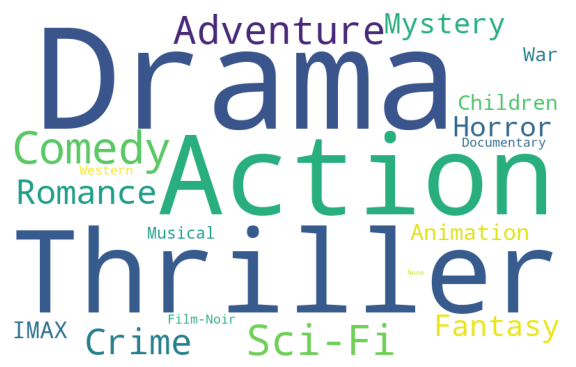

In [13]:
# Nube de palabras para los generos
wordcloud = WordCloud(width=800, height=500, background_color = 'white',
                      min_font_size=6, contour_color='black', contour_width=2).generate_from_frequencies(genres)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [14]:
#Peliculas más puntuadas
df_n_ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)
df_n_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Pulp Fiction (1994),4.429423,84546
Star Wars: Episode IV - A New Hope (1977),4.189101,66668
"Matrix, The (1999)",4.375106,56432
Inception (2010),4.446055,46900
"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",4.532649,38592
"Shawshank Redemption, The (1994)",4.629119,35200
Arrival (2016),4.273675,30158
"Dark Knight, The (2008)",4.390674,28470
The Martian (2015),4.104433,26620


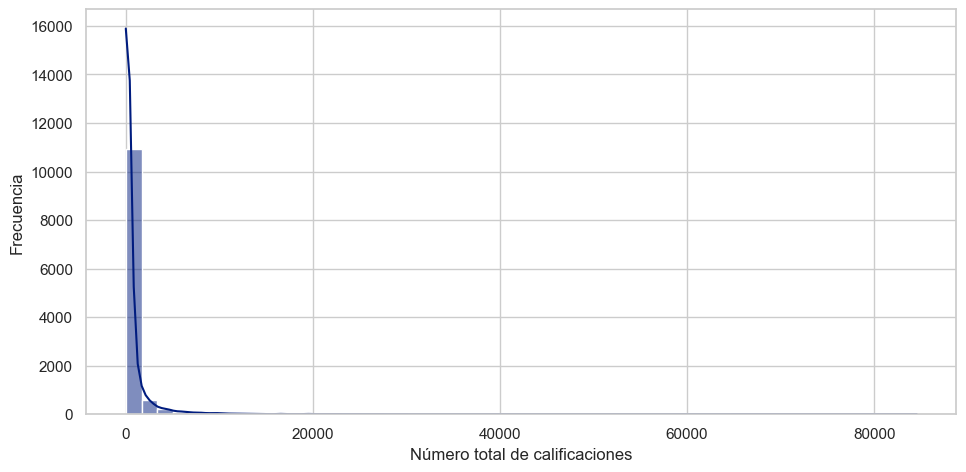

In [15]:
# histograma de la distribución de frecuencia del número total de calificaciones en el DataFrame
plt.figure(figsize=(10,5))
sns.histplot(df_n_ratings['total ratings'], bins=50, kde=True)  # kde=True incluye la estimación de densidad kernel
plt.xlabel('Número total de calificaciones')
plt.ylabel('Frecuencia')
plt.show()

In [16]:
# Calificaciones promedio más altas en función de la columna 'mean ratings'.
df_n_ratings.sort_values('mean ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Take Care of My Cat (Goyangileul butaghae) (2001),5.0,9
Celine and Julie Go Boating (Celine et Julie vont en bateau) (1974),5.0,18
Nil By Mouth (1997),5.0,9
"Our Lady of the Assassins (Virgen de los sicarios, La) (2000)",5.0,11
Haiku Tunnel (2001),5.0,42
Winnie the Pooh and the Day of Concern (1972),5.0,10
"Benny Goodman Story, The (1955)",5.0,40
Duets (2000),5.0,72
"Dance of Reality, The (Danza de la realidad, La) (2013)",5.0,52


In [17]:
print('Nº total de usuarios que han valorado con 5,0 : ', len(df_n_ratings.loc[df_n_ratings['mean ratings'] == 5]), '\n')
print('Nº total de usuarios individuales que han valorado con 5,0 : ', len(df_n_ratings.loc[(df_n_ratings['mean ratings'] == 5) 
                                                                           & (df_n_ratings['total ratings'] == 1)]))

Nº total de usuarios que han valorado con 5,0 :  160 

Nº total de usuarios individuales que han valorado con 5,0 :  0


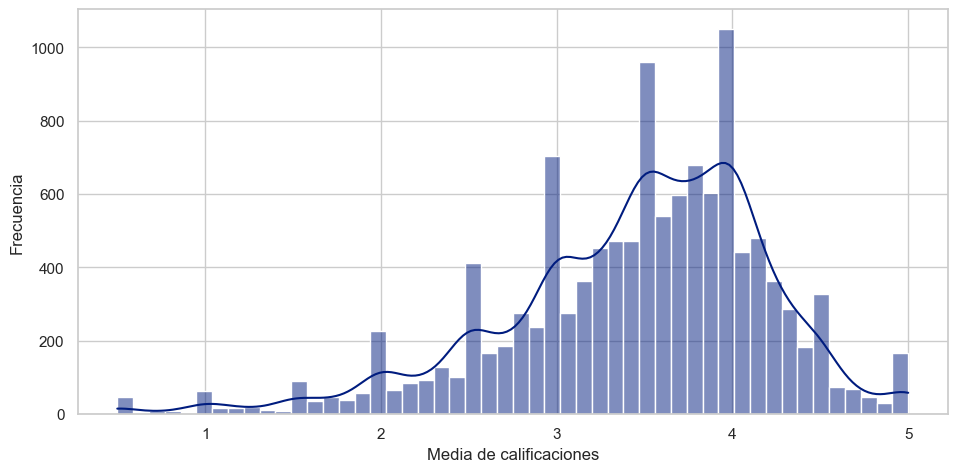

In [18]:
plt.figure(figsize=(10,5))
sns.histplot(df_n_ratings['mean ratings'], bins=50, kde=True)
plt.xlabel('Media de calificaciones')
plt.ylabel('Frecuencia')
plt.show()

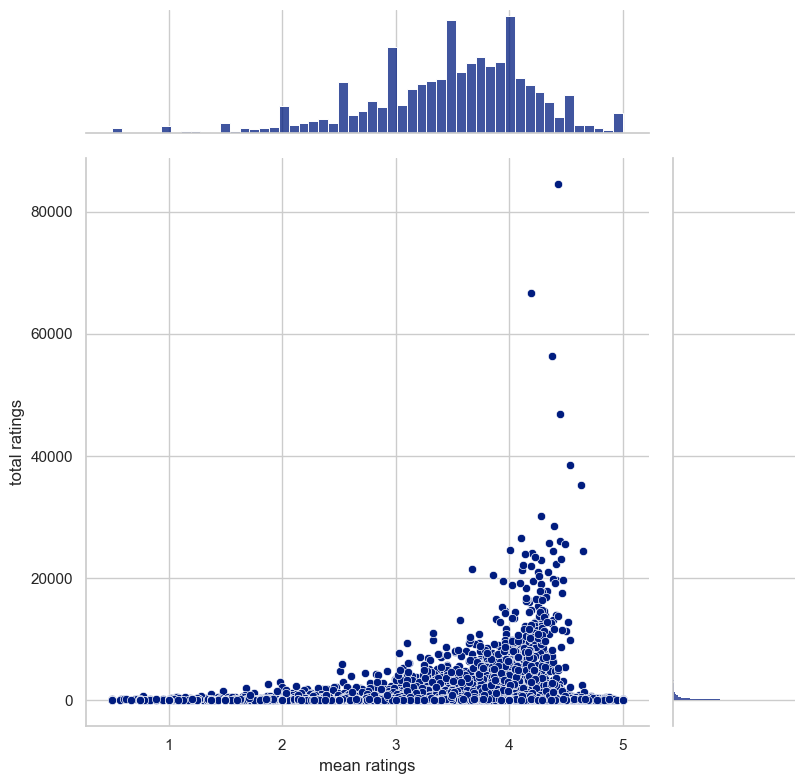

In [19]:
# Mean Ratings vs Total Number of Ratings
sns.jointplot(x='mean ratings', y='total ratings', data=df_n_ratings, height=8, ratio=4)


## MODELS

In [81]:
df.head(3)

,userId,movieId,timestamp_rt,tag_by_user,timestamp_tags,gen_tag,title,genres,tagId,relevance,rating
1561133,60101,2571,1053445162,dystopia,1244667471,hitman,"Matrix, The (1999)",Action|Sci-Fi|Thriller,512,0.12625,5.0
1499330,42923,1228,1330057917,classic,1330057913,nocturnal,Raging Bull (1980),Drama,710,0.60700,4.0
1048680,7620,34532,1144937579,Magick,1144937622,true story,"Skeleton Key, The (2005)",Drama|Horror|Mystery|Thriller,1047,0.05750,5.0


In [106]:

# La asignación de índices únicos y la posterior división del DataFrame en conjuntos de entrenamiento y 
# prueba pueden ser necesarias por varias razones en el contexto de modelos de recomendación y 
# aprendizaje automático en general:

# Índices numéricos: Algunos algoritmos y modelos de aprendizaje automático requieren que las 
# entradas sean números enteros. Al asignar índices únicos a los usuarios y películas, 
# se asegura de que cada entidad esté representada por un identificador numérico único, 
# lo que facilita el procesamiento por parte de los modelos.

# Consistencia en los datos de entrada: Al asignar índices únicos y transformar los datos originales, 
# se crea una representación consistente y única para cada usuario y película en el conjunto de datos. 
# Esto facilita el manejo y la interpretación de los datos durante el preprocesamiento y el entrenamiento 
# del modelo.

# Reproducibilidad: La división aleatoria del DataFrame en conjuntos de entrenamiento y 
# prueba utilizando np.random.rand() con una semilla (random_state) proporciona reproducibilidad. 
# Esto significa que si vuelves a ejecutar el código con la misma semilla, obtendrás la misma 
# división de datos, lo que es útil para comparar resultados y depurar el código.

# Evaluación del modelo: La división en conjuntos de entrenamiento y prueba es esencial para 
# evaluar el rendimiento del modelo. El conjunto de entrenamiento se utiliza para entrenar el modelo,
# mientras que el conjunto de prueba se reserva para evaluar su rendimiento en datos no vistos.

# En resumen, estas operaciones son prácticas comunes en el preprocesamiento de datos para modelos 
# de aprendizaje automático, especialmente cuando se trata de conjuntos de datos que contienen 
# variables categóricas o identificadores que deben ser representados de manera numérica y 
# cuando se busca garantizar la consistencia y la reproducibilidad en el procesamiento de datos.

df_aux = df.copy()
# userId	movieId	timestamp_rt	tag_by_user	timestamp_tags	gen_tag	title	genres	tagId	relevance	rating
df_aux = df_aux[['userId', 'movieId','tag_by_user','genres','rating']]

# Crear diccionarios de asignación de índices únicos
user_unique_ids = df_aux['userId'].unique()
movie_unique_ids = df_aux['movieId'].unique()

userid2idx = {user_id: idx for idx, user_id in enumerate(user_unique_ids)}
movieid2idx = {movie_id: idx for idx, movie_id in enumerate(movie_unique_ids)}

# Aplicar la asignación de índices únicos al DataFrame
df_aux['userId'] = df_aux['userId'].apply(lambda x: userid2idx[x])
df_aux['movieId'] = df_aux['movieId'].apply(lambda x: movieid2idx[x])

# Dividir dataset en entrenamiento y test
X = df_aux[['userId', 'movieId']]  # UserId y movieId
Y = df_aux['rating']                # rating

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(x_train.shape , x_test.shape)

(80000, 2) (20000, 2)


### Definicicón de parametros

In [112]:
# Definición del número de factores latentes
n_latent_factors = 50
# learning_rate = 5e-4
lr = 5e-4
#Optimizador 
optimizer = Adam(learning_rate = lr)
#Función de perdida
loss_function = 'mse'
#Bartch
batch_size = 128
#Epoch
epochs = 20
#Paciencia early stopping
pte = 5

In [114]:
es = EarlyStopping(monitor="val_loss",
                   mode="min",
                   verbose=1,
                   patience=pte)

In [115]:
def train_model(model):
    # Entrenar el modelo y obtener el objeto history
    history = model.fit(x=[x_train['userId'], x_train['movieId']], y=y_train, 
                       batch_size= batch_size, epochs=epochs, verbose= 1, 
                       validation_data=([x_test['userId'], x_test['movieId']], y_test))
    
    return history

In [119]:
def plot_loss(history):
    rcParams['figure.figsize'] = 10, 5
    plt.plot(history.history['loss'], 'g')
    plt.plot(history.history['val_loss'], 'b')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.grid(True)
    plt.show()


### Arquitectura 1

In [113]:
# Obtención del número único de usuarios y películas en el conjunto de datos de calificaciones
n_users, n_movies = len(df['userId'].unique()), len(df['movieId'].unique())

# Definición de la entrada del usuario
user_input = Input(shape=(1,), name='User_Input')

# Creación de la capa de embedding para usuarios
user_embeddings = Embedding(input_dim=n_users, output_dim=n_latent_factors, input_length=1, 
                            name='User_Embedding')(user_input)
user_vector = Flatten(name='User_Vector')(user_embeddings)

# Definición de la entrada de la película
movie_input = Input(shape=(1,), name='Movie_Input')

# Creación de la capa de embedding para películas
movie_embeddings = Embedding(input_dim=n_movies, output_dim=n_latent_factors, input_length=1, 
                             name='Movie_Embedding')(movie_input)
movie_vector = Flatten(name='Movie_Vector')(movie_embeddings)

# Combinación de los vectores de usuario y película mediante el producto punto
merged_vectors = dot([user_vector, movie_vector], name='Dot_Product', axes=1)

# Creación del modelo utilizando Model API de Keras
model_a1 = Model([user_input, movie_input], merged_vectors)

model_a1.summary()
# Visualizar el modelo de Keras en formato DOT y luego lo convierte a formato SVG para mostrarlo
# SVG(model_to_dot( model_a1,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

#Compilar modelo
model_a1.compile(loss=loss_function, optimizer = optimizer)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Movie_Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User_Embedding (Embedding)     (None, 1, 50)        346900      ['User_Input[0][0]']             
                                                                                                  
 Movie_Embedding (Embedding)    (None, 1, 50)        432300      ['Movie_Input[0][0]']            
                                                                                            

Epoch 1/20
625/625 [==============================] - 5s 7ms/step - loss: 15.6872 - val_loss: 15.5444
Epoch 2/20
625/625 [==============================] - 4s 7ms/step - loss: 14.6098 - val_loss: 13.0963
Epoch 3/20
625/625 [==============================] - 4s 6ms/step - loss: 10.5047 - val_loss: 8.8275
Epoch 4/20
625/625 [==============================] - 4s 6ms/step - loss: 6.8758 - val_loss: 6.3173
Epoch 5/20
625/625 [==============================] - 4s 6ms/step - loss: 4.8206 - val_loss: 4.8749
Epoch 6/20
625/625 [==============================] - 4s 6ms/step - loss: 3.5640 - val_loss: 3.9628
Epoch 7/20
625/625 [==============================] - 4s 7ms/step - loss: 2.7288 - val_loss: 3.3493
Epoch 8/20
625/625 [==============================] - 4s 6ms/step - loss: 2.1451 - val_loss: 2.9210
Epoch 9/20
625/625 [==============================] - 5s 7ms/step - loss: 1.7221 - val_loss: 2.6127
Epoch 10/20
625/625 [==============================] - 4s 6ms/step - loss: 1.4059 - val_loss: 2

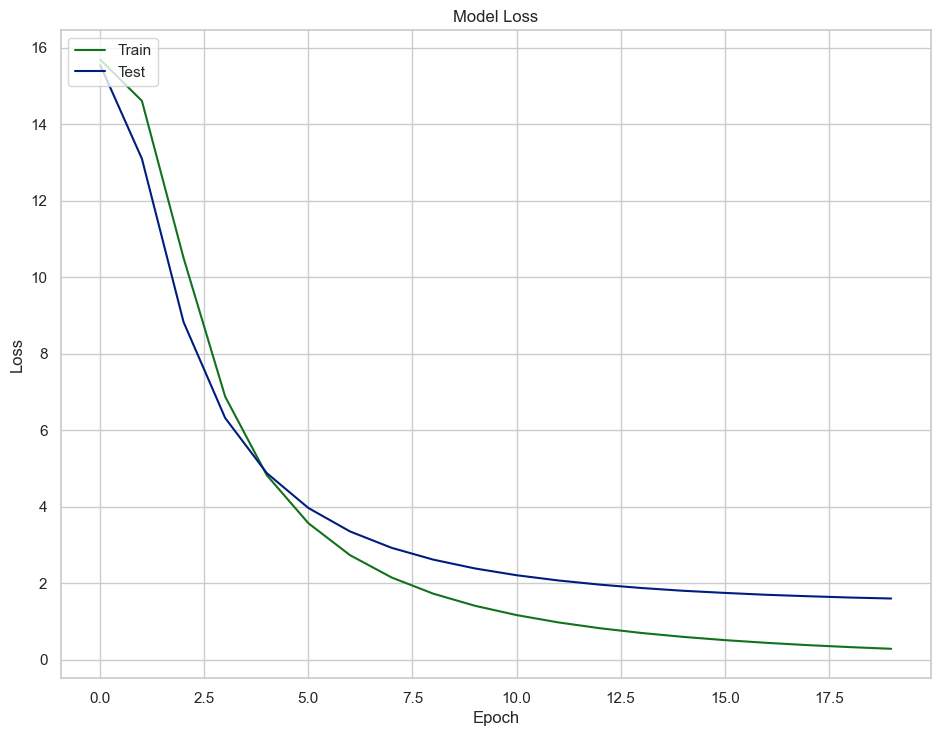

In [117]:
history_mda1 = train_model(model_a1)
plot_loss(history_mda1)

### Arquitectura 2

In [118]:
# Obtener el número único de películas y usuarios en el DataFrame
n_movies = len(df['movieId'].unique())
n_users = len(df['userId'].unique())

# Definir la capa de entrada para el usuario con un solo valor entero (userId)
user_input = Input(shape=(1,), name='user_input', dtype='int64')

# Crear la capa de embedding para usuarios
user_embedding = Embedding(n_users, n_latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)  # Aplanar la salida de la capa de embedding
user_vec = Dropout(0.40)(user_vec)  # Aplicar Dropout para regularización

# Definir la capa de entrada para la película con un solo valor entero (movieId)
movie_input = Input(shape=(1,), name='movie_input', dtype='int64')

# Crear la capa de embedding para películas
movie_embedding = Embedding(n_movies, n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)  # Aplanar la salida de la capa de embedding
movie_vec = Dropout(0.40)(movie_vec)  # Aplicar Dropout para regularización

# Calcular la similitud entre los vectores de usuario y película mediante el producto punto
similarity = dot([user_vec, movie_vec], name='Similarity-Dot-Product', axes=1)

# Definir una capa de red neuronal para procesar la similitud calculada
nn_inp = Dense(96, activation='relu')(similarity)
nn_inp = Dropout(0.4)(nn_inp)  # Aplicar Dropout para regularización
# nn_inp = BatchNormalization()(nn_inp)  # Normalización por lotes (comentada, opcional)
nn_inp = Dense(1, activation='relu')(nn_inp)

# Crear el modelo utilizando Model API de Keras
model_a2 = Model([user_input, movie_input], nn_inp)
model_a2.summary()  # Mostrar resumen del modelo en términos de parámetros y capas

# Compilar el modelo con la función de pérdida y el optimizador especificados
model_a2.compile(loss=loss_function, optimizer=optimizer)


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 50)        346900      ['user_input[0][0]']             
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 50)        432300      ['movie_input[0][0]']            
                                                                                            

Epoch 1/20
625/625 [==============================] - 5s 7ms/step - loss: 1.9483 - val_loss: 0.9351
Epoch 2/20
625/625 [==============================] - 5s 7ms/step - loss: 0.9498 - val_loss: 0.7755
Epoch 3/20
625/625 [==============================] - 4s 7ms/step - loss: 0.7675 - val_loss: 0.6997
Epoch 4/20
625/625 [==============================] - 4s 7ms/step - loss: 0.6523 - val_loss: 0.6593
Epoch 5/20
625/625 [==============================] - 5s 8ms/step - loss: 0.5964 - val_loss: 0.6334
Epoch 6/20
625/625 [==============================] - 4s 7ms/step - loss: 0.5433 - val_loss: 0.6163
Epoch 7/20
625/625 [==============================] - 5s 8ms/step - loss: 0.5100 - val_loss: 0.6015
Epoch 8/20
625/625 [==============================] - 5s 8ms/step - loss: 0.4766 - val_loss: 0.5954
Epoch 9/20
625/625 [==============================] - 5s 7ms/step - loss: 0.4443 - val_loss: 0.5864
Epoch 10/20
625/625 [==============================] - 5s 9ms/step - loss: 0.4238 - val_loss: 0.5789

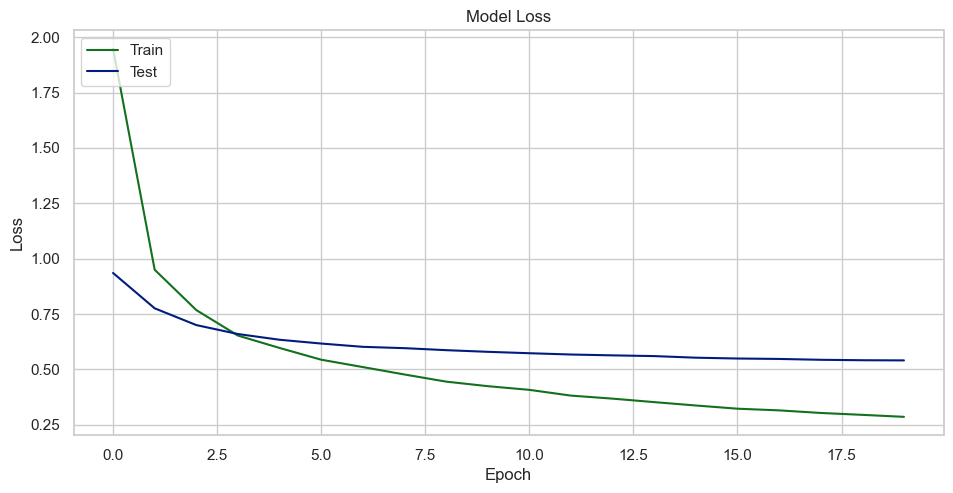

In [120]:
history_mda2 = train_model(model_a2)
plot_loss(history_mda2)

### Arquitectura 3